In [ ]:

! pip install tensorflow
import tensorflow

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import requests

In [3]:
from google.colab import files

def upload_image_to_folder ( image_url , folder_path) :


  # Folder path where you want to save the image
  folder_path = folder_path + "/"

  # Make sure the folder exists, create it if not
  os.makedirs(folder_path, exist_ok=True)

  # Get the file name from the URL
  file_name = os.path.basename(image_url)

  # Combine the folder path and file name
  file_path = os.path.join(folder_path, file_name)

  # Send a GET request to the URL
  response = requests.get(image_url)

  # Check if the request was successful (status code 200)
  if response.status_code == 200:
      # Save the content to the specified file path
      with open(file_path, "wb") as file:
          file.write(response.content)
      print(f"Image downloaded and saved at: {file_path}")
  else:
      print(f"Failed to download image. Status code: {response.status_code}")




In [4]:
#Copy Paste your image address
Content_image_url = "https://live.staticflickr.com/3706/9325086299_1e98db9ea1_h.jpg"
Style_image_url = "https://www.thesprucecrafts.com/thmb/gpfu0knQhpKCUfRs2RlGTkHyvwk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/6738942065_38647e4fd7_o-56a6e6d53df78cf77290d9b8.png"
original_img_folder_path = "/content/original"
style_img_folder_path = "/content/style"
upload_image_to_folder(Content_image_url , original_img_folder_path )
upload_image_to_folder(Style_image_url , style_img_folder_path )

Image downloaded and saved at: /content/original/9325086299_1e98db9ea1_h.jpg
Image downloaded and saved at: /content/style/6738942065_38647e4fd7_o-56a6e6d53df78cf77290d9b8.png


In [5]:
def get_image_from_folder (folder_path ) :
  for img in os.listdir(folder_path ) :
    if img.endswith ((".jpg", ".jpeg", ".png")) :
      img_path = os.path.join(folder_path, img)
      img_array = cv2.imread(img_path)
      return img_array , img_path

In [6]:

content_image , content_img_path = get_image_from_folder (original_img_folder_path)
style_image , style_img_path = get_image_from_folder(style_img_folder_path)

(850, 1600, 3)
(850, 1600, 3)


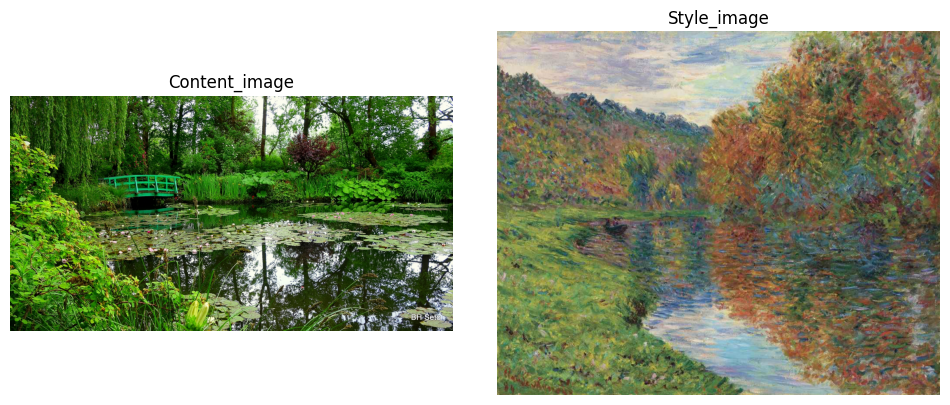

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_two_images(image1, image2):
  print(image1.shape)
  rgb_image1 = image1[..., ::-1]
  rgb_image2 = image2[..., ::-1]
  print(rgb_image1.shape)
  # Create a new figure with two subplots
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Display the first image on the left subplot
  axes[0].imshow(rgb_image1)
  axes[0].set_title('Content_image')
  axes[0].axis('off')

  # Display the second image on the right subplot
  axes[1].imshow(rgb_image2)
  axes[1].set_title('Style_image')
  axes[1].axis('off')

  # Adjust spacing between subplots
  plt.subplots_adjust(wspace=0.1)

  # Show the plot
  plt.show()

# Example usage:
# Replace 'image1.jpg' and 'image2.jpg' with the paths to your images
plot_two_images(content_image, style_image)





In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(content_img_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [9]:
def preprocess_image(image_path):
    # Util function to open, resize and format
    # pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [10]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# This is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) /\
      (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] \
          - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] \
          - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [11]:
# HIDE OUTPUT
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * \
      total_variation_loss(combination_image)
    return loss

In [13]:
@tf.function
def compute_loss_and_grads(combination_image, \
                  base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, \
                base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [14]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(content_img_path)
style_reference_image = preprocess_image(style_img_path)
combination_image = tf.Variable(preprocess_image(content_img_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=6341.84
Iteration 200: loss=2831.19
Iteration 300: loss=1912.17
Iteration 400: loss=1517.29
Iteration 500: loss=1300.84
Iteration 600: loss=1164.40
Iteration 700: loss=1070.36
Iteration 800: loss=1001.48
Iteration 900: loss=948.86
Iteration 1000: loss=907.28
Iteration 1100: loss=873.58
Iteration 1200: loss=845.71
Iteration 1300: loss=822.26
Iteration 1400: loss=802.22
Iteration 1500: loss=784.91
Iteration 1600: loss=769.82
Iteration 1700: loss=756.57
Iteration 1800: loss=744.84
Iteration 1900: loss=734.38
Iteration 2000: loss=725.01
Iteration 2100: loss=716.56
Iteration 2200: loss=708.92
Iteration 2300: loss=701.98
Iteration 2400: loss=695.65
Iteration 2500: loss=689.85
Iteration 2600: loss=684.52
Iteration 2700: loss=679.60
Iteration 2800: loss=675.06
Iteration 2900: loss=670.86
Iteration 3000: loss=666.97
Iteration 3100: loss=663.35
Iteration 3200: loss=659.98
Iteration 3300: loss=656.84
Iteration 3400: loss=653.91
Iteration 3500: loss=651.17
Iteration 3600: loss=

In [15]:
import matplotlib.pyplot as plt

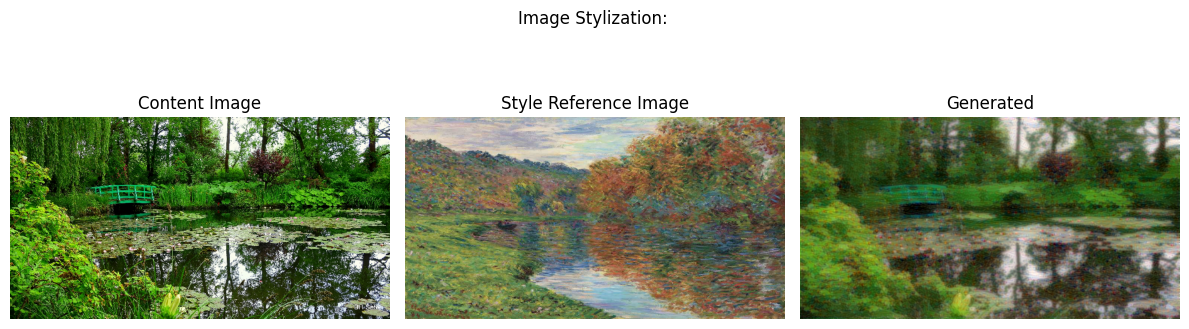

In [16]:
generated = cv2.imread("/content/generated_at_iteration_4000.png")

base_image_p = deprocess_image(base_image.numpy())
style_reference_image_p = deprocess_image(style_reference_image.numpy())
rgb_generated = generated[..., ::-1]
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first image
axs[0].imshow(base_image_p)
axs[0].set_title("Content Image")

# Plot the second image
axs[1].imshow(style_reference_image_p)
axs[1].set_title("Style Reference Image")

# Plot the third image
axs[2].imshow(rgb_generated)
axs[2].set_title("Generated")

# Remove the x and y ticks (optional)
for ax in axs:
    ax.axis('off')

# Set a common title for the entire plot (optional)
fig.suptitle("Image Stylization: ")

# Adjust subplot spacing (optional)
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# HIDE OUTPUT
from google.colab import files
files.download(result_prefix + "_at_iteration_4000.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>